
=== SKAB === [13167.0/37222]===================================================

===== Conditional Gaussian Scorer==============================================
{'ConditionalGaussianScorer': {'grace_period': 951, 't_a': 1298, 'threshold': 0.9975164889718193}, 'Rolling': {'window_size': 6752}}
Avg. latency per sample: 1.2580855402209348ms
Pred anomalous samples | events | proportion:           14084    | 1093  | 37.84%
Found samples | events | proportion:                    6578     |       | 49.96%

===== Half-Space Trees=========================================================
{'HalfSpaceTrees': {'height': 13, 'n_trees': 5, 'window_size': 313}, 'QuantileFilter': {'q': 0.6515994227573121}}
Avg. latency per sample: 0.19686021974422271ms
Pred anomalous samples | events | proportion:           7479     | 6662  | 20.09%
Found samples | events | proportion:                    2781     |       | 21.12%

===== One-Class SVM============================================================
{'OneCla

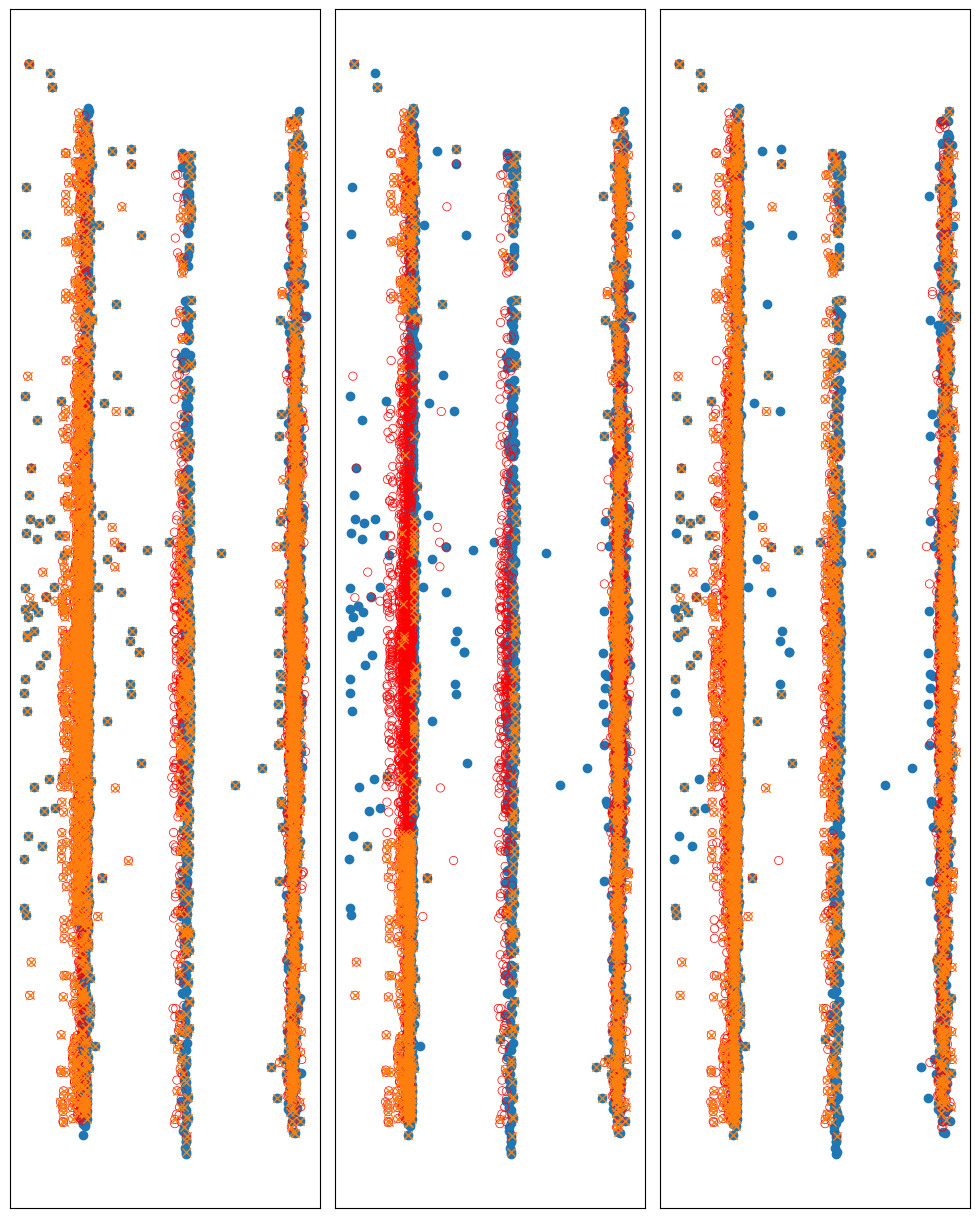

In [119]:
# IMPORTS
import os
import random
import sys
import warnings

from pathlib import Path
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from river import anomaly, preprocessing, utils
from river.metrics import F1, ROCAUC
from river.metrics.base import BinaryMetric
from sklearn.decomposition import PCA

sys.path.insert(1, str(Path().resolve().parent))
from functions.anomaly import ConditionalGaussianScorer  # noqa: E402
from functions.compose import build_model, convert_to_nested_dict  # noqa: E402
from functions.proba import MultivariateGaussian  # noqa: E402
from functions.evaluate import print_stats, progressive_val_predict  # noqa: E402

# CONSTANTS
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)


# FUNCTIONS
def tune_train_model(steps, df, val_kwargs: dict = {}, **params):
    params = convert_to_nested_dict(params)
    model = build_model(steps, params)
    metric: BinaryMetric = F1()
    try:
        val_kwargs.update(params.get("Val", {}))
        progressive_val_predict(
            model, df, [metric], print_every=0, print_final=False, **val_kwargs
        )

        return metric.get()
    except Exception as e:
        print(e)
        return 0


def get_random_samples(df: pd.DataFrame, num_samples=10000):
    if len(df) <= num_samples:
        return df
    else:
        return df.sample(n=num_samples, random_state=RANDOM_STATE)


def plot_detection(df: pd.DataFrame, y_pred):
    df["pred"] = y_pred
    if "anomaly" in df.columns:
        df = get_random_samples(df)
        if len(df.columns) >= 4:
            # Separate the feature columns from the target column ("anomaly")
            X = df.drop(columns=["anomaly", "pred"])
            y = df["anomaly"]
            y_pred = df["pred"]

            # Apply PCA to reduce the feature columns to 2 components
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X)

            # Create a new DataFrame with the reduced components and "anomaly" column
            df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
            df_pca["anomaly"] = y.values
            df_pca["pred"] = y_pred.values
        else:
            print(True)
            df_pca = pd.DataFrame(df.reset_index().copy())
            df_pca.columns = ["PC1", "PC2", "anomaly", "pred"]

        # Plot the 2D scatter plot
        plt.scatter(
            df_pca[df_pca["anomaly"] == 0]["PC1"],
            df_pca[df_pca["anomaly"] == 0]["PC2"],
        )
        plt.scatter(
            df_pca[df_pca["anomaly"] == 1]["PC1"],
            df_pca[df_pca["anomaly"] == 1]["PC2"],
            facecolors="none",
            edgecolors="r",
            linewidths=0.5,
        )
        plt.scatter(
            df_pca[df_pca["pred"] == 1]["PC1"],
            df_pca[df_pca["pred"] == 1]["PC2"],
            marker="x",
            linewidths=1,
        )  # type: ignore
        plt.xticks(())
        plt.yticks(())


def save_results_y(df_ys, path):
    dir_path = path
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    df_ys.to_csv(f"{dir_path}/ys.csv", index=False)


def save_results_metrics(metrics_res, path):
    dir_path = path
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    metrics_res.to_csv(f"{dir_path}/metrics.csv")


# MODS
class QuantileFilter(anomaly.QuantileFilter):
    def __init__(
        self, anomaly_detector, q: float, protect_anomaly_detector=True
    ):
        super().__init__(
            anomaly_detector=anomaly_detector,
            protect_anomaly_detector=protect_anomaly_detector,
            q=q,
        )

    def predict_one(self, *args):
        score = self.score_one(*args)
        return self.classify(score)


# SETTINGS

# DETECTION ALGORITHMS
detection_algorithms = [
    (
        "Conditional Gaussian Scorer",
        [[ConditionalGaussianScorer, [utils.Rolling, MultivariateGaussian]]],
        {
            "ConditionalGaussianScorer__threshold": (0.65, 0.99994),
            "Rolling__window_size__round": (150, 10000),
            "ConditionalGaussianScorer__t_a__int": (50, 2000),
            "ConditionalGaussianScorer__grace_period__round": (50, 1000),
        },
    ),
    (
        "Half-Space Trees",
        [preprocessing.MinMaxScaler, [QuantileFilter, anomaly.HalfSpaceTrees]],
        {
            "QuantileFilter__q": (0.65, 0.99994),
            "HalfSpaceTrees__n_trees__round": (1, 20),
            "HalfSpaceTrees__height__round": (1, 16),
            "HalfSpaceTrees__window_size__round": (100, 400),
        },
    ),
    (
        "One-Class SVM",
        [preprocessing.StandardScaler, [QuantileFilter, anomaly.OneClassSVM]],
        {
            "QuantileFilter__q": (0.65, 0.99994),
            "OneClassSVM__intercept_lr": (0.005, 0.02),
        },
    ),
    # (   "Local Outlier Factor",
    #     [[QuantileFilter, anomaly.LocalOutlierFactor]],
    #     {
    #         "QuantileFilter__q": (0.85, 0.99994),
    #         "LocalOutlierFactor__n_neighbors__round": (0,200),
    #         }
    #     ),
]

# DATASETS
datasets = [
    # {
    #     "name": "Load Balancing",
    #     "data": pd.read_csv("data/load_balancing.csv", index_col=0).dropna(
    #         axis=0
    #     ),
    #     "anomaly_col": "anomaly",
    #     "drop": "MPC:Request Status Code",
    # },
    {
        "name": "SKAB",
        "data": pd.read_csv(
            "data/multivariate/alldata_skab.csv", index_col=0
        ).dropna(axis=0),
        "anomaly_col": "is_anomaly",
        "drop": "changepoint",
    },
    # {
    #     "name": "YAHOO",
    #     "data": pd.read_csv(
    #         "data/multivariate/yahoo_sub_5.csv",
    #         index_col=0).dropna(axis=0),
    #     "anomaly_col": "is_anomaly",
    #     "drop": None},
    # {
    #     "name": "Room Occupancy",
    #     "data": pd.read_csv(
    #         "data/multivariate/Occupancy/room-occupancy-1.test.csv",
    #         index_col=0).dropna(axis=0),
    #     "anomaly_col": "is_anomaly",
    #     "drop": None},
    # {
    #     "name": "Archive",
    #     "data": pd.read_csv(
    #         "data/multivariate/archive/TimeSeries.csv"
    #         ).head(80000).tail(20000),
    #     "anomaly_col": pd.read_csv(
    #         "data/multivariate/archive/labelsTimeSeries.csv"
    #         ).head(80000).tail(20000)['label'],
    #     "drop": None},
]

# PLOT CONFIG
plt.figure(figsize=(len([1, 1, 1]) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)
plot_num = 1

# RUN
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for dataset in datasets:
        # PREPROCESS DATA
        df = dataset["data"]
        df.index = pd.to_timedelta(
            range(0, len(df)), "T"
        ) + pd.Timestamp.utcnow().replace(microsecond=0)
        if isinstance(dataset["anomaly_col"], str):
            df = df.rename(columns={dataset["anomaly_col"]: "anomaly"})
        elif isinstance(dataset["anomaly_col"], pd.Series):
            df_y = dataset["anomaly_col"]
            df["anomaly"] = df_y.rename("anomaly").values
        if dataset["drop"] is not None:
            df = df.drop(columns=dataset["drop"])
        print(
            f"\n=== {dataset['name']} === [{sum(df['anomaly'])}/{len(df)}]".ljust(
                80, "="
            )
        )

        df_ys = df[["anomaly"]].copy()
        # RUN EACH MODEL AGAINST DATASET
        for alg in detection_algorithms:
            print(f"\n===== {alg[0]}".ljust(80, "="))
            # INITIALIZE OPTIMIZER
            pbounds = alg[2]
            mod_fun = partial(tune_train_model, alg[1], df, {})

            # INITIALIZE METRICS
            metrics_list = []

            # TUNE HYPERPARAMETERS
            optimizer = BayesianOptimization(
                f=mod_fun,
                pbounds=pbounds,
                verbose=2,
                random_state=RANDOM_STATE,
                allow_duplicate_points=True,
            )
            logger = JSONLogger(
                path=f"./.results/{dataset['name']}-{alg[0]}.log"
            )
            optimizer.subscribe(Events.OPTIMIZATION_END, logger)
            optimizer.maximize(init_points=20, n_iter=100)
            params = convert_to_nested_dict(optimizer.max["params"])
            print(params)
            model = build_model(alg[1], params)
            if hasattr(model, "seed"):
                model.seed = RANDOM_STATE  # type: ignore
            if hasattr(model, "random_state"):
                model.random_state = RANDOM_STATE  # type: ignore
            # USE TUNED MODEL
            # PROGRESSIVE PREDICT
            y_pred, _ = progressive_val_predict(model, df, metrics=None)

            # SAVE PREDICITONS
            df_ys[f"{alg[0]}__{params}"] = y_pred

            #  PRINT OUT LAST DETECTION RESULTS
            print_stats(df, y_pred)
            plt.subplot(len(datasets), len(detection_algorithms), plot_num)
            plot_detection(df, y_pred)
            plot_num += 1

        # LOAD RESULTS
        #  Save
        dir_path = f".results/{dataset['name']}"
        save_results_y(df_ys, f".results/{dataset['name']}")

plt.show()

In [20]:
import sys

from pathlib import Path

from river.metrics import (
    F1,
    Precision,
    Recall,
    ROCAUC,
    RollingROCAUC,
    ClassificationReport,
)
from river.stats import Mean

sys.path.insert(1, str(Path().resolve().parent))
from functions.evaluate import batch_save_evaluate_metrics


class MeanRollingROCAUC(RollingROCAUC):
    def __init__(self, window_size=1000, pos_val=True):
        super().__init__(window_size, pos_val)
        self.mean = Mean()

    def update(self, y_true, y_pred):
        super().update(y_true, y_pred)
        self.mean.update(super().get())
        return self

    def get(self):
        return self.mean.get()


metrics = [
    Precision(),
    Recall(),
    F1(),
    ROCAUC(),
    MeanRollingROCAUC(),
    ClassificationReport(),
]

path = ".results/"

batch_save_evaluate_metrics(metrics, path, task="classification")